# **I’m Something of a Painter Myself**

### Coursera: Introduction to DL: Week 5 Assignment
---

 # Brief description of the problem and data

**Challenge Problem**

To develop models that classify paintings based on their style. This involves using GAN techniques to analyze various attributes of paintings and determine their artistic style. The challenge is to differentiate between different artistic styles, which can be subtle and varied. The goal is to train a model that can generalize well across various styles and provide accurate predictions on a diverse set of paintings.
(Source: Kaggle)


**Data used**

The dataset provided for the competition includes a collection of paintings with their respective style labels.
* Images: A large set of paintings represented in image files.
* Labels: Corresponding labels for each image indicating the style of the painting (e.g., Impressionism, Cubism, Surrealism, etc.).

# Exploratory Data Analysis (EDA) & Preprocessing

**Step 1: Importing necessary libraries and modules for the dataset**



In [3]:
import os
import cv2
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict

import re
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback
from kaggle_datasets import KaggleDatasets
plt.style.use("ggplot")

2024-06-19 16:04:23.376656: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 16:04:23.376766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 16:04:23.521051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

i) TPU configuration

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on: ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    tpu_strategy = tf.distribute.get_strategy()
print('Number of replicas:', tpu_strategy.num_replicas_in_sync)

AUTO_TUNE = tf.data.experimental.AUTOTUNE
    
print("version:",tf.__version__)

Number of replicas: 1
version: 2.15.0


**Step 2: Understanding the Data**

i) Loading the dataset

In [6]:
GCS_PATH = KaggleDatasets().get_gcs_path('gan-getting-started')

monet_files = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
photos_files = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

ii) Counting the records and files used in the dataset

In [7]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

monet_samples = count_data_items(monet_files)
photo_samples = count_data_items(photos_files)

EPOCHS = 30
BATCH_SIZE = 4
print("Monet TFRecord files:", len(monet_files))
print("Monet image files:", monet_samples)
print("Photo TFRecord files:", len(photos_files))
print("Photo image files:", photo_samples)
print("EPOCHS:",EPOCHS)

Monet TFRecord files: 5
Monet image files: 300
Photo TFRecord files: 20
Photo image files: 7038
EPOCHS: 30


Inference: The training data has 7038 photos and 300 Monet paintings which can be used to train the GAN.

In [8]:
 # defining image size
IMAGE_SIZE = [256, 256]

**Step 3: Image Augmentation**

When augmenting data for GANs, particularly in style transfer tasks, it’s crucial to proceed with caution. Applying transformations that significantly alter the data’s style—such as brightness, contrast, or saturation—may hinder the generator’s ability to learn the fundamental style effectively. Therefore, we are limiting our augmentation to spatial transformations, including flips, rotations, and crops.

In [9]:
# decoding images
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# read the TFRecord files
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

i) Random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting

In [10]:
# Resize an image to bigger height and width Randomly crop to the target size Randomly rotate the image
def data_augment(image):
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    # Crops (Random jitter)
    if p_crop > .5:
        image = tf.image.resize(image, [286, 286]) # resizing to 286 x 286 x 3
        image = tf.image.random_crop(image, size=[256, 256, 3]) # randomly cropping to 256 x 256 x 3
        if p_crop > .9:
            image = tf.image.resize(image, [300, 300])
            image = tf.image.random_crop(image, size=[256, 256, 3])
     # 90º rotations
    if p_rotate > .9:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .7:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flips (random mirroring)
    if p_spatial > .6:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        if p_spatial > .9:
            image = tf.image.transpose(image)
    
    return image

ii) Helper functions

In [11]:
# load dataset
def load_dataset(filenames):
    data = tf.data.TFRecordDataset(filenames)
    data = data.map(read_tfrecord, num_parallel_calls=AUTO_TUNE)
    return data

# define GAN dataset
def get_gan_dataset(monet_files, photo_files, augment=None, repeat=True, shuffle=True, batch_size=1):

    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    
    if augment:
        monet_ds = monet_ds.map(augment, num_parallel_calls=AUTO_TUNE)
        photo_ds = photo_ds.map(augment, num_parallel_calls=AUTO_TUNE)
        
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTO_TUNE)
    photo_ds = photo_ds.prefetch(AUTO_TUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

# displaying samples
def display_samples(dataset, nrows, ncols):
    ds_iter = iter(dataset)
    plt.figure(figsize=(15, int(15*nrows/ncols)))
    for j in range(nrows*ncols):
        monet_sample = next(ds_iter)
        plt.subplot(nrows,ncols,j+1)
        plt.axis('off')
        plt.imshow(monet_sample[0] * 0.5 + 0.5)
    plt.show()
    
data = get_gan_dataset(monet_files, photos_files, augment=data_augment, repeat=True, shuffle=True, batch_size=BATCH_SIZE)

**Step 4: Visualizing The Data**

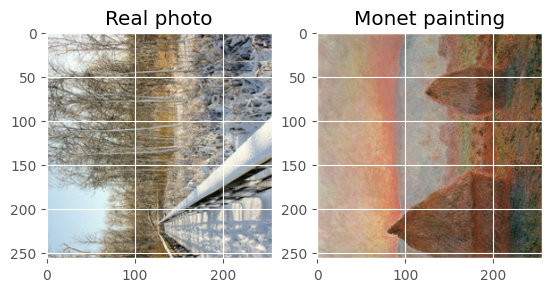

In [12]:
example_monet , example_photo = next(iter(data))
# Visualizing the real photo
plt.subplot(121)
plt.title('Real photo')
plt.imshow(example_photo[2] * 0.5 + 0.5)

# Visualizing the Monet painting
plt.subplot(122)
plt.title('Monet painting')
plt.imshow(example_monet[2]* 0.5 + 0.5)

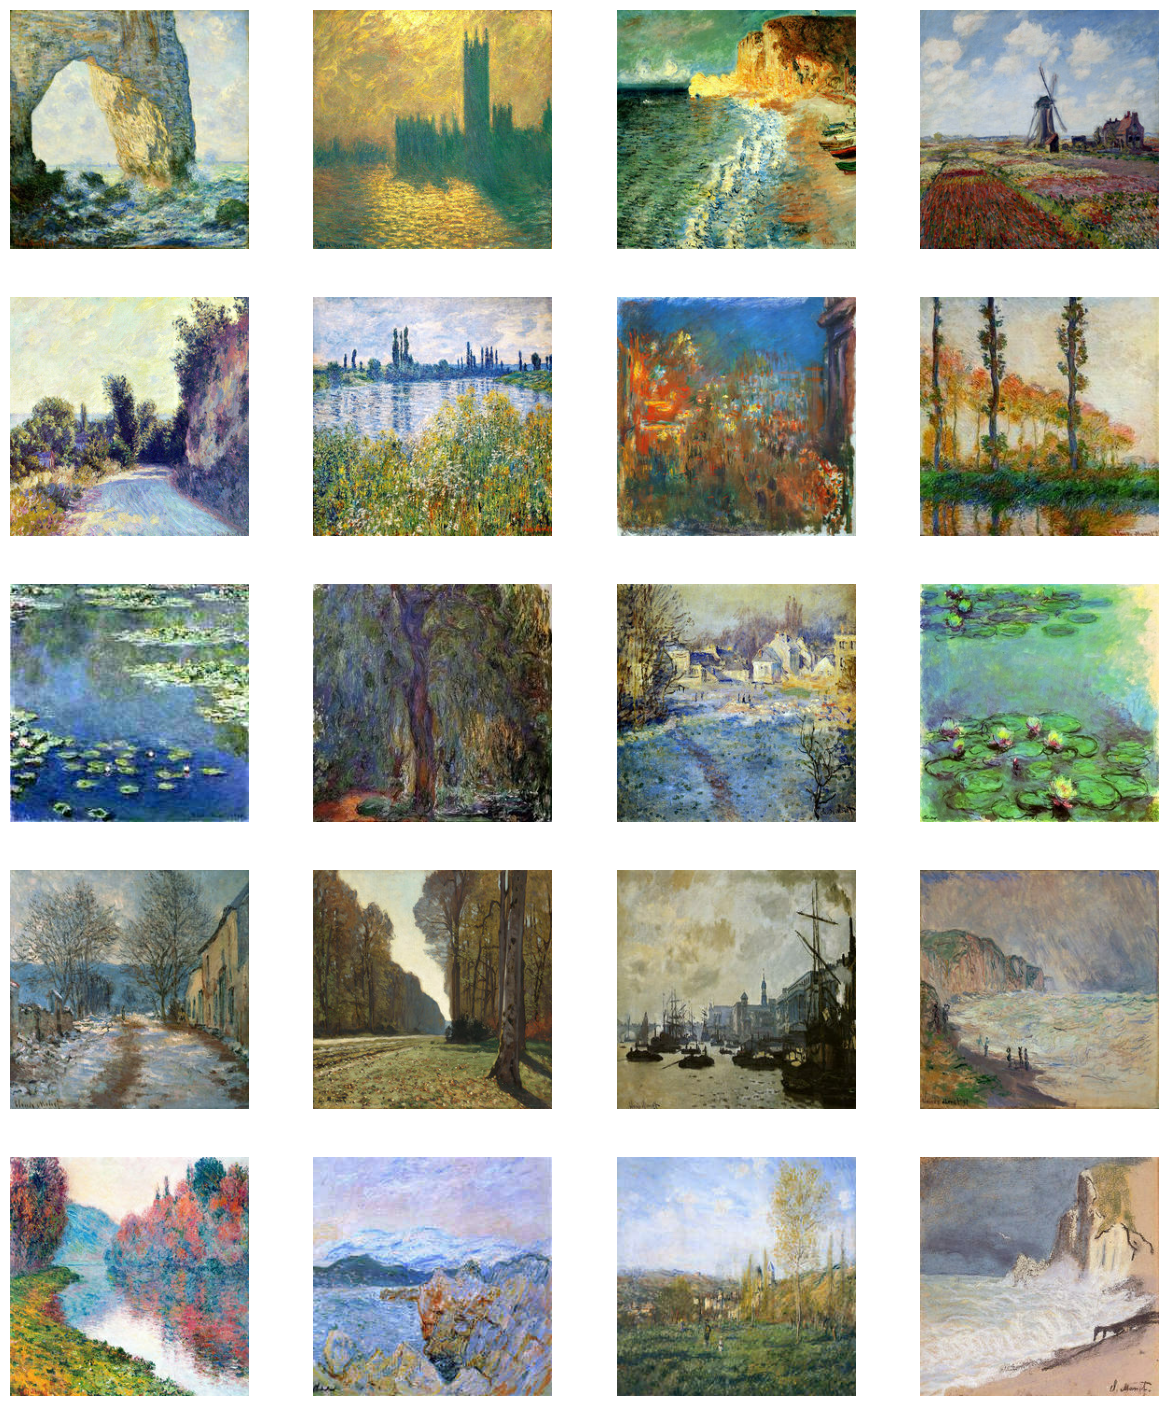

In [13]:
# Displaying samples
display_samples(load_dataset(monet_files).batch(1), 5, 4)

 # Model Architecture

To construct the model, we will undertake the following procedures:

* Construct the Generator
* Develop the Discriminator
* Establish Loss Functions:
    1. Generator Loss
    2. Discriminator Loss
    3. Adversarial Loss
    4. Cycle Loss
* Identity Loss
* Define the Optimizers

**Step 1: Construct the Generator Model**

The role of generator within the CycleGAN architecture is to create images pertaining to a specific domain. CycleGAN features two such generators: one transforms photos into Monet-style paintings, while the other converts Monet paintings back into photos. Below is the architecture of the standard CycleGAN generator:

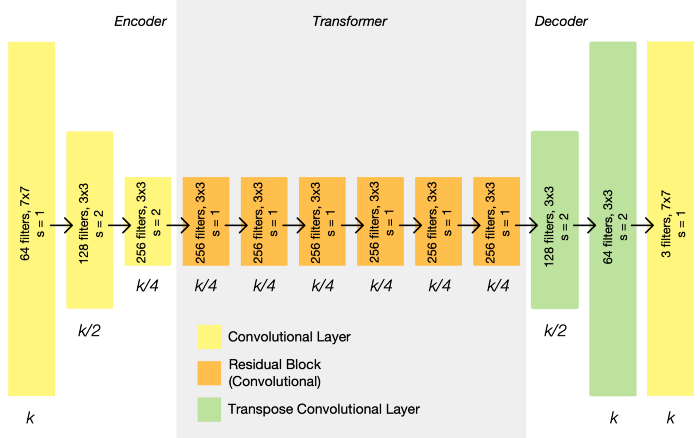

Source: https://towardsdatascience.com/translate-a-horse-to-a-zebra-cyclegan-6c3e12e40f53

For this project, a Cycle-GAN shall be used. This architecture is designed to minimize the cycle loss, whih measures the ability of the network to translate from regular photos to Monet-style paintings, and then back to photos without losing key characteristics of the original image. The cycle-consistent mechanism ensures that the generated images retain the essence of the input while adopting the style of the target, making it ideal for tasks where paired training data is not available.

i) Defining helper functions to Downsample and Upsample images to feed into Generator

Implements 2 basic blocks:
- A Downsample block that aims to downsample input by 2 
    - Input -> Conv2D -> (OPT) GroupNorm (InstanceNorm) -> LeakyReLU
- An Upsample block that aims to upsample input by 2
    - Input -> ConvTranspose2d -> GroupNorm (InstanceNorm) -> (OPT) Dropout -> ReLU

In [14]:
def downsample(filters, size, i_normal=True):
    initializer = tf.random_normal_initializer(0., 0.04)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    result = keras.Sequential()
    # Convolutional layer
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    # Normalization layer
    if i_normal:
        result.add(layers.BatchNormalization(gamma_initializer=gamma_init))
    # Activation layer
    result.add(layers.LeakyReLU())
    
    return result

def upsample(filters, size, dropout=False):
     # Normalization layer
    initializer = tf.random_normal_initializer(0., 0.04)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    # Transpose convolutional layer
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer,use_bias=False))
    # Instance Normalization
    result.add(layers.BatchNormalization(gamma_initializer=gamma_init))
    # Dropout layer
    if dropout:
        result.add(layers.Dropout(0.5))
    # Activation layer
    result.add(layers.ReLU())

    return result

ii) Defining the Generator model

A simple Generator network made out of an Encoder and Decoder with skip connections just like in U-Net
- Encoder
    - 8 Downsample blocks that take input image and produce an output of shape
- Decoder
    - 6 Upsample blocks that the latent features and produce an output of shape
- Final layer
    - A final ConvTranspose2D layer that takes the output of Decoder and upsamples it once again so that the final output is of required shape

In [15]:
def generator_fn():
    OUTPUT_CHANNELS = 3
    data = layers.Input(shape=[256,256,3])
    down_sample = [
        downsample(64, 4, i_normal=False), downsample(128, 4), downsample(256, 4), 
        downsample(512, 4), downsample(512, 4), downsample(512, 4), downsample(512, 4),downsample(512, 4),
    ]

    up_sample = [
        upsample(512, 4, dropout=True), upsample(512, 4, dropout=True),upsample(512, 4, dropout=True), 
        upsample(512, 4), upsample(256, 4), upsample(128, 4), upsample(64, 4),
    ]
    
    initialize = tf.random_normal_initializer(0., 0.02)
     # batch size 256 256 3
    final = layers.Conv2DTranspose(3, 7,strides=2,padding='same',kernel_initializer=initialize,activation='tanh')
    inputs = data
    # Downsampling through the model
    skip_conn = []
    for down in down_sample:
        inputs = down(inputs)
        skip_conn.append(inputs)
        
    skip_conn = reversed(skip_conn[:-1])
    # Upsampling 
    for up, skip in zip(up_sample, skip_conn):
        inputs = up(inputs)
        inputs = layers.Concatenate()([inputs, skip])

    inputs = final(inputs)
    generator = keras.Model(inputs=data, outputs=inputs)

    return generator

In [16]:
# testing the generator
sample_generator = generator_fn()
sample_generator.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,438,531 (207.67 MB)

 Trainable params: 54,427,651 (207.63 MB)

 Non-trainable params: 10,880 (42.50 KB)

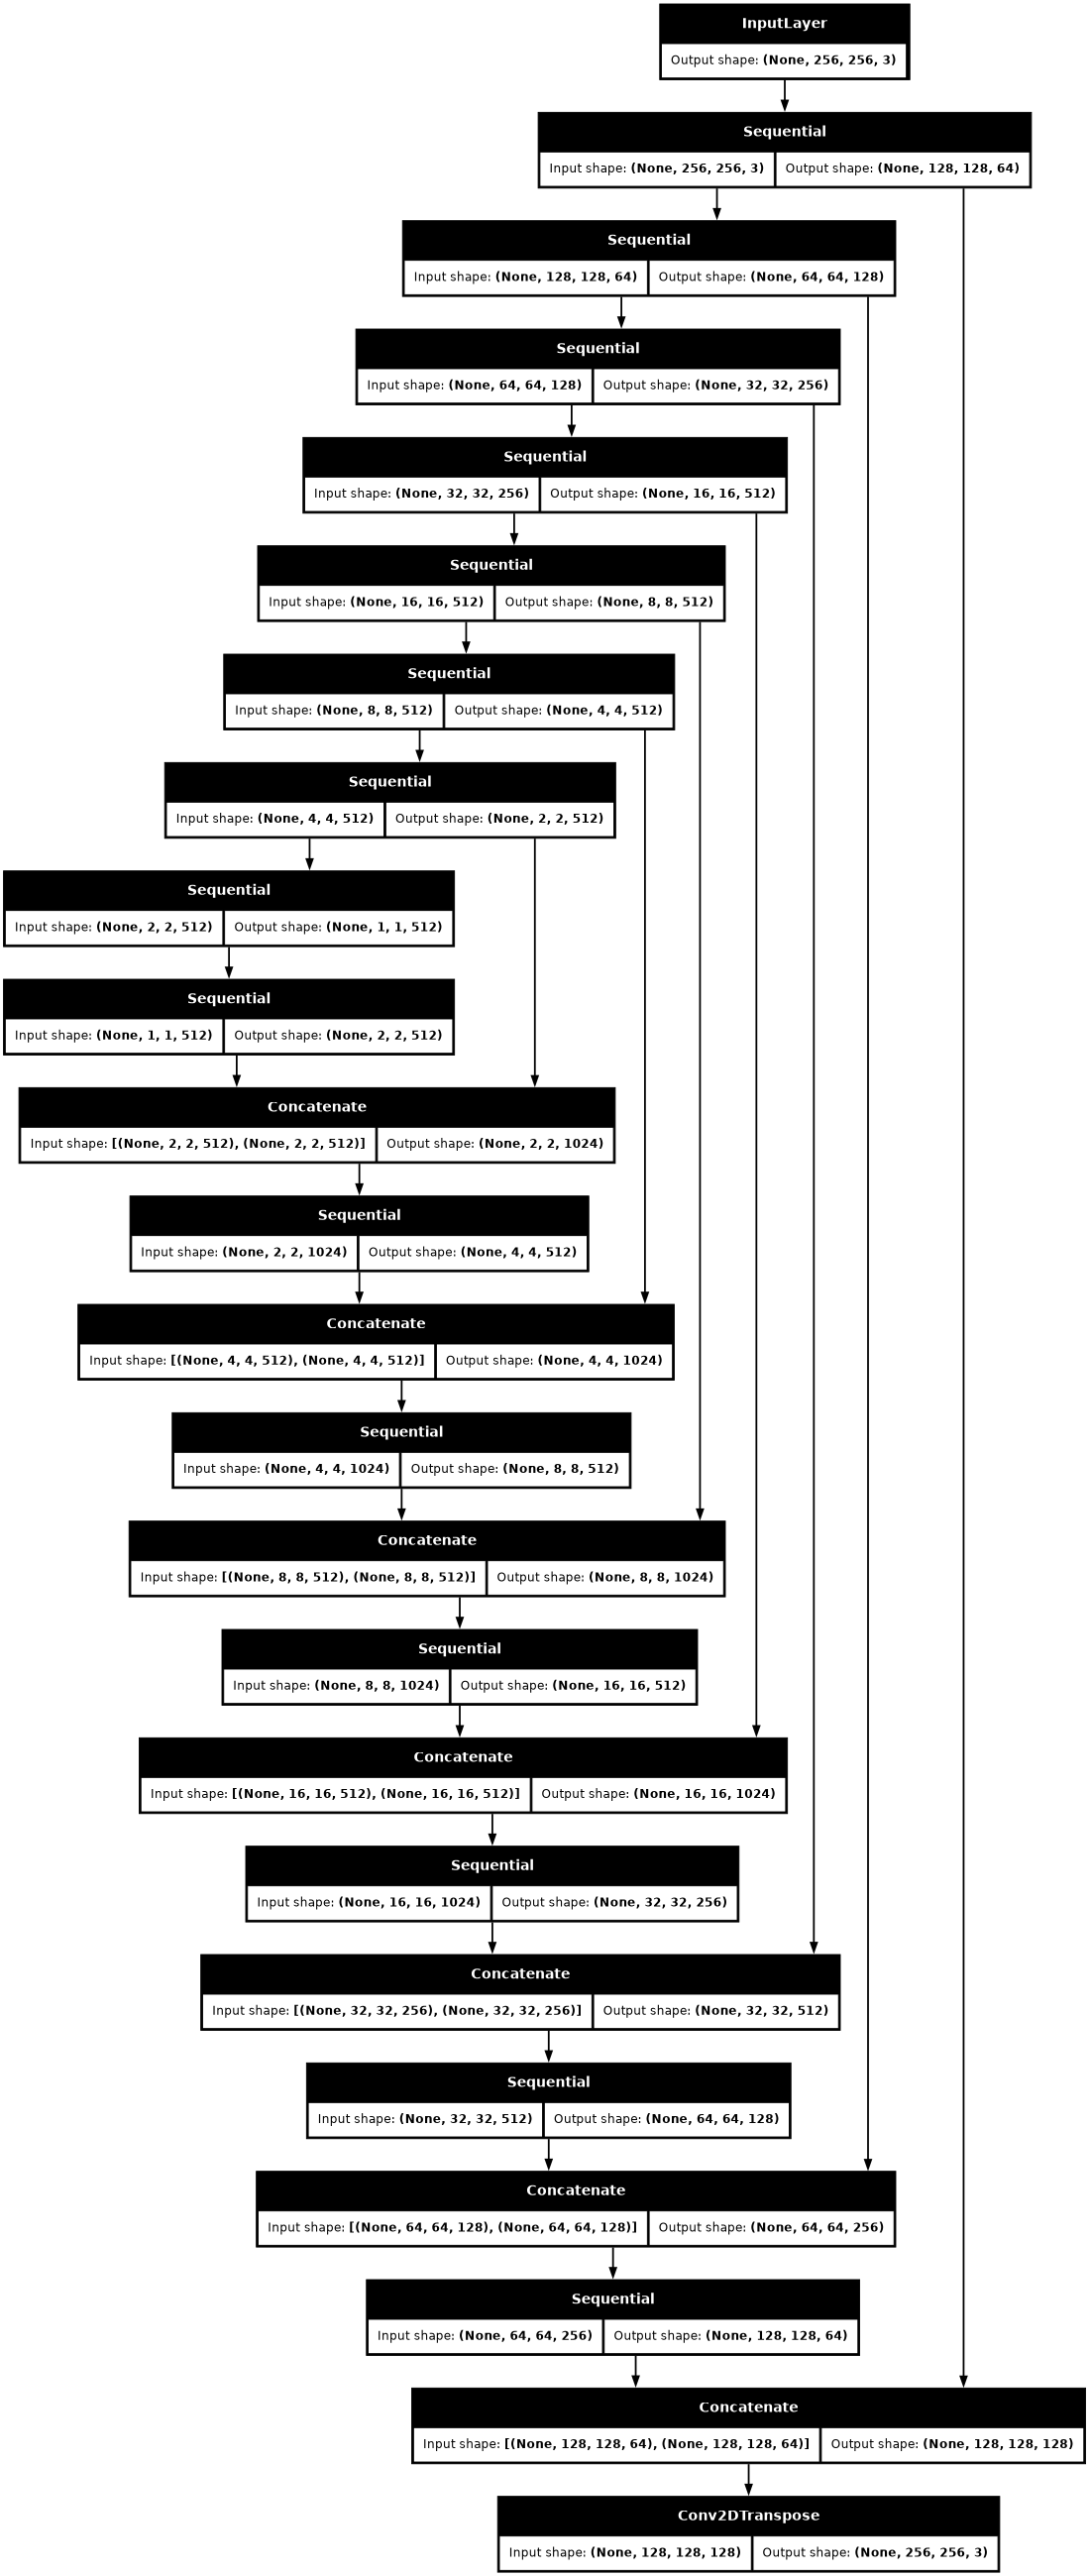

In [17]:
tf.keras.utils.plot_model(sample_generator, show_shapes=True, dpi=64)

**Step 2: Construct the Discriminator Model**

The discriminator is responsible for differentiating real images from images that have been generated by a generator model. Below is the architecture of the standard CycleGAN discriminator:

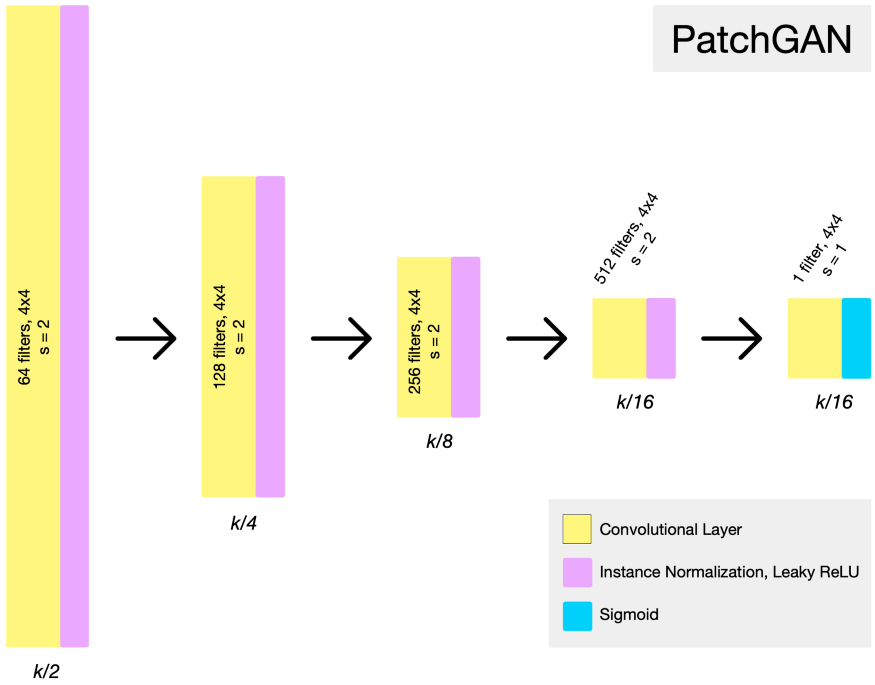

The task of the discriminator is to tell whether an input image (i.e. the output of a generator) is original or not. The architecture employed by the discriminator is a convolutional network known as PatchGAN. Rather than determining the authenticity of the entire image, this architecture assesses whether segments of the image are real or fabricated. Similar to the generator’s encoder, which comprises downsample-k blocks that compress the image, the discriminator’s architecture includes:

* Convolution
* Instance Normalization
* Leaky ReLU

These layers work in tandem to analyze patches of the image, allowing for a more detailed and localized assessment of authenticity.

In [18]:
def discriminator_fn():
    tf_init = tf.random_normal_initializer(0., 0.02)
    k_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    data = layers.Input(shape=[256, 256, 3], name='input_image')
    inputs = data
    # downsampling
    down_sample_1 = downsample(64, 4, False)(inputs) 
    down_sample_2 = downsample(128, 4)(down_sample_1) 
    down_sample_3 = downsample(256, 4)(down_sample_2)
    # adding padding
    zero_pad_1 = layers.ZeroPadding2D()(down_sample_3)
    conv = layers.Conv2D(512, 7, strides=2,
                         kernel_initializer=tf_init,
                         use_bias=False)(zero_pad_1) 
    norm1 = layers.BatchNormalization(gamma_initializer=k_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad_2 = layers.ZeroPadding2D()(leaky_relu)
    final = layers.Conv2D(1, 7, strides=2,kernel_initializer=tf_init)(zero_pad_2)
    
    discriminator = tf.keras.Model(inputs=inputs, outputs=final)
    return discriminator

In [19]:
# testing the discriminator
sample_discriminator = discriminator_fn()
sample_discriminator.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_16 (Sequential)      │ (None, 64, 64, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (None, 32, 32, 256)    │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     6,422,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 16, 16, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 5, 5, 1)        │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,109,633 (27.12 MB)

 Trainable params: 7,107,841 (27.11 MB)

 Non-trainable params: 1,792 (7.00 KB)

**Step 3: Building & Implementing CycleGAN Model**

*(Due to limited knowledge about GANs, various online resources have been consulted to build this model)*

CycleGAN is built of 4 neural nets

- 2 Generators
    - Monet Generator - To go from Photo to Monet 
    - Photo Generator - To got from Monet to Photo
- 2 Discriminators
    - Monet Discriminator - To tell whether input is a real/fake monet 
    - Photo Discriminator - To tell whether input is a real/fake photo 

i) Defining the model

In [20]:
with tpu_strategy.scope():
    monet_generator = generator_fn() # transforms photos to Monet-esque paintings
    photo_generator = generator_fn() # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn() 
    
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=20,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
             # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)
        
        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

ii) Defining loss functions

In [21]:
with tpu_strategy.scope():
    # Discriminator loss (0: fake, 1: real)
    # discriminator loss outputs the average of the real and generated loss
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with tpu_strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with tpu_strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

iii) Defining separate optimizers for the generator and discriminator networks in the architecture (specifically targeting Monet and photo)

In [22]:
with tpu_strategy.scope(): # ensures these optimizers and potentially the following training loop are executed efficiently on TPUs
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

iv) Compiling the CycleGAN model

In [23]:
# assigning specific optimizers for generators and discriminators along with loss functions to evaluate their performance during training. 
with tpu_strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, 
        monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

**Step 4: Fitting the model**

In [24]:
cycle_gan_model.fit(
    data,
    epochs=1,
    steps_per_epoch=(max(monet_samples, photo_samples)//BATCH_SIZE),
)

2024-06-19 16:06:42.405866: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 517.195, expected 2065.37
2024-06-19 16:06:42.405933: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 774.525, expected 3093.12
2024-06-19 16:06:42.405944: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 781.843, expected 3123.32
2024-06-19 16:06:42.405953: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 538.02, expected 2148.93
2024-06-19 16:06:42.405962: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 778.338, expected 3109.89
2024-06-19 16:06:42.405971: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 1174.06, expected 4691.68
2024-06-19 16:06:42.405980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 1170.24, expected 4675.99
2024-06-19 16:06:42.405989: E external/local_xla/xla/ser

1759/1759 ━━━━━━━━━━━━━━━━━━━━ 671s 303ms/step - monet_disc_loss: 0.5696 - monet_gen_loss: 5.5660 - photo_disc_loss: 0.5570 - photo_gen_loss: 5.6590


*The model could only trained once due to time restrictions*

# Results and Analysis

We shall now assess the performance of the generator models by examining the quality of the generative cycle. This involves using a photo to generate a Monet-style painting and then using that painting to recreate the original photo.

**Step 1: Photo (input) -> Monet (generated) -> Photo (generated)**

i) Making Predictions & saving results for Kaggle submissions

In [25]:
import PIL
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [31]:
import os
os.makedirs('../imagesZ/')

predict_and_save(load_dataset(photos_files).batch(1), monet_generator, '../images/')

In [32]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'

In [33]:
print(f"Number of generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Number of generated samples: 7038


ii) Helper function to display

In [34]:
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
    
        plt.subplot(121)
        plt.title("Input image")
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')

        plt.subplot(122)
        plt.title("Generated image")
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


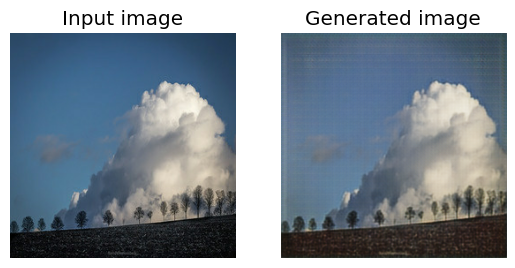

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


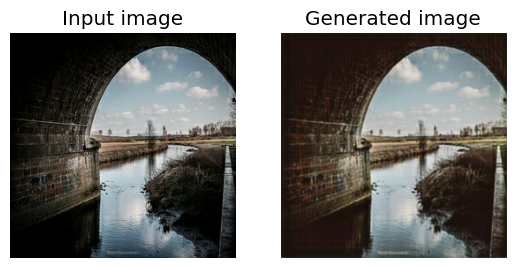

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


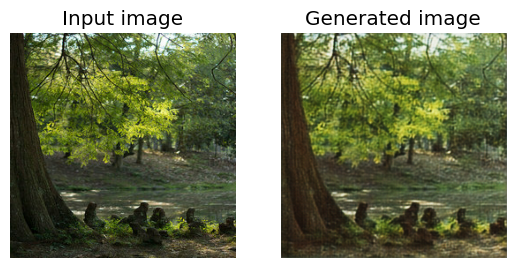

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


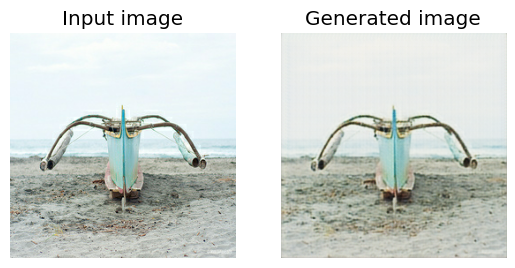

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


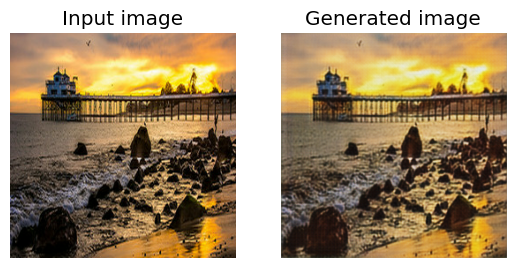

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


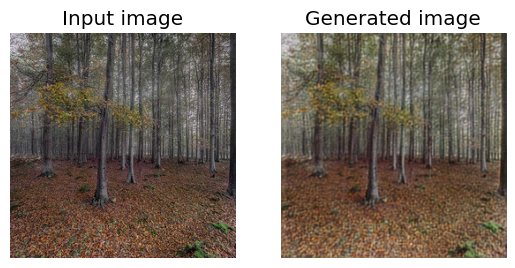

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


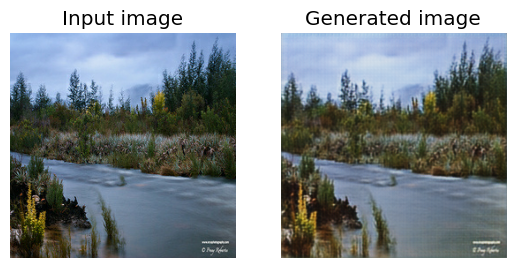

In [35]:
display_generated_samples(load_dataset(photos_files).batch(1), monet_generator, 7)

**Conclusion:** 

Successfully implemented a CycleGAN model to translate images from one domain (photos) to another (Monet paintings). The model achieved promising results in generating visually appealing and coherent Monet-style paintings from input photos. However, there is still room for improvement in terms of refining the details and capturing the nuances of the Monet style. Further training with a larger dataset and hyperparameter tuning could potentially enhance the model's performance. Additionally, exploring different network architectures and loss functions could lead to further improvements in the quality of the generated images.

Furthermore, it has been observed that images generated appear remarkably realistic. Additionally, optimization of the learning rate has revealed that a range between 1e-4 and 1e-5 yields the best results. A common issue with images generated by GANs is that the often show some undisered artifacts, a very common on is known as "checkerboard artifacts", a good practice is to inspect some of the images to see its quality and if some of these undisered artifacts are present.